<hr style="height:5px;border-width:2;color:gray;background-color:#000000"> 
<center><h1>CS 144 - Spring 2022 - Mini-Mapping Tool</h1></center>
<center><h1>Due: Sunday, June 5th, 2022 @ 11:59pm</h1></center>

### Enter your information below:

<div style="color: #000000;background-color: #EEEEFF">
    Your Name (submitter): Jarod Najera <br>
    Your student ID (submitter): 862179022
<br>
<br>
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>
<br>    
<br>
<b>Instruction for submissions:</B> when you have completed this project, download this .ipynb file to your computer by left-clicking on the file name, and submit to <a href="https://elearn.ucr.edu/">Canvas</A> by the deadline. 
<br>
<br>
<B>Late work:</B> There is no late deadline for the final project, except for the most serious circumstances (illness, medical emergency, etc.) which have to be documented.
</div>


<hr style="height:5px;border-width:2;color:gray;background-color:#000000"> 
<center><h1>Generator</h1></center>
<br>

In the first part of this project, you will write a <B>read generator</B>, that takes in input 
<UL>
<LI>a reference genome $R$ in <A HREF="https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Web&PAGE_TYPE=BlastDocs&DOC_TYPE=BlastHelp">FASTA</A> format (for instance <A HREF="http://www.cs.ucr.edu/~stelo/cs144spring22/data/BD.fa">the BD genome</A>)</LI>
    <LI>integer parameter $N$ </LI>
    <li>integer parameter $L$ </LI>
</UL>
and generates a new file in FASTA format containing $N$ reads composed of exactly $L$ symbols obtained by sampling the genome $R$ at random positions. For instance if $N=100000$ and $L=100$, the generator will produce a FASTA file containing 100 thousand reads from random positions in the genome, each of which is 100 nucleotides long. 
    
The FASTA headers should contain the original genomic position of each read so the mapper can verify that the correctness of the positions. For instance

&gt;R1 1,1043<br>
ACTTACTTTACTATTCATTCTACATTCTA<br>
&gt;R2 3,54654<br>
TATTTATTTCTCTTATCTATCTATCTATA<br>

is a FASTA file with two reads named R1 and R2. R1 originates from position 1043 and R2 originate from position 54654 in the genome $R$.
    
You are allowed to use Biopython to read and write FASTA files. It is mandatory to acknowledge sources.

In [9]:
## YOUR CODE HERE
## OK to use Biopython
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import random

def ReadGenerator(R, N, L):
    # 1. Read FASTA file and get genome
    genome = ''
    i = 0
    for seq_record in SeqIO.parse(R, 'fasta'):
        if i > 4:
            break
        genome += str(seq_record.seq)
        i += 1
    
    # 2. Perform N reads of L symbols from R at random positions
    n = len(genome)
    reads = {}
    for i in range(1, N+1):
        j = random.randrange(n-L+1)
        label = f'R{i} {j}'
        curr_read = genome[j:j+L]
        reads[label] = curr_read
    
    # 3. Write reads to FASTA file
    f = open('reads.fa', 'x')
    for key in reads.keys():
        write_record = SeqRecord(Seq(reads[key]), key, '', '')
        SeqIO.write(write_record, f, 'fasta')
    f.close()
        
    
# main
if __name__ == '__main__':
    print('Making reads FASTA')
    ReadGenerator('bd_genome.fa', 100000, 100)

Making reads FASTA


<hr style="height:5px;border-width:2;color:gray;background-color:#000000"> 
<center><h1>Mapper</h1></center>
<br>

In the second part, you will write a <B>read mapper</B>, that takes in input
<UL>
<LI>a reference genome $R$ in FASTA format</LI>
<LI>a set $S$ of reads in FASTA format (generated by the generator)</LI>
</UL>
The read mapper finds the position(s) of each read in $S$ in the genome $R$, and counts how many are mapped correctly by comparing them to the original position stored in the FASTA header. You can use the original position stored in the FASTA headers <B>only</B> to verify the correctness. 

You are allowed to use any Python package that implements any of the data structures we saw in class (suffix arrays, suffix trees, FM-index (BWT), or hash tables, etc). You should be able install packages using `!pip install package`. It is mandatory to acknowledge sources.

Collect experimental results on time spent by the mapper for several choices of $|R|$ (genome size) and $N$. You can keep $L$ fixed at 100. Is the time linear in $|R|$, or is it super-linear? Is the time linear in $N$ or is it super-linear?

### Works Cited: Using the suffix-trees 0.3.0 library: https://pypi.org/project/suffix-trees/

In [97]:
!pip install suffix-trees

Defaulting to user installation because normal site-packages is not writeable


In [10]:
## YOUR CODE and EXPERIMENTAL RESULTS HERE
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import time

# Works Cited: Using the suffix-trees 0.3.0 library: https://pypi.org/project/suffix-trees/
from suffix_trees import STree


def ReadMapper(R, S):
    # 1. Make dictionary from reads FASTA file
    gen_reads = {}
    for seq_record in SeqIO.parse(S, 'fasta'):
        curr_pos = seq_record.description
        curr_pos = curr_pos.split(' ')
        curr_pos = curr_pos[1]
        curr_sequence = str(seq_record.seq)
        gen_reads[curr_sequence] = int(curr_pos)
    
    # uncomment for small tests
    # print('Printing reads dictionary: {SEQUENCE: RANDOM_POSITION_IN_GENOME}\n', gen_reads, '\n')
    
    # 2. Read genome FASTA file and get genome
    genome = ''
    i = 0
    for seq_record in SeqIO.parse(R, 'fasta'):
        if i > 4:
            break
        genome += str(seq_record.seq)
        i += 1
    
    # 3. Find occurrence of each sequence in the genome 
    # and keep track of all positions of where its found
    # using a suffix tree
    seq_pos = {}
    st = STree.STree(genome)
    for seq in gen_reads.keys():
        found_pos = st.find_all(seq)
        seq_pos[seq] = found_pos
        
    # uncomment for small tests
    # print('Printing all found positions dictionary: {SEQUENCE: [ALL_POSITIONS_IN_GENOME]}\n', seq_pos, '\n')
    
    # 4. Check how many sequences were mapped correctly
    correct_maps = 0
    expected_correct = len(gen_reads.keys())
    for seq in gen_reads.keys():
        map_pos = gen_reads[seq]
        all_pos = seq_pos[seq]
        
        if map_pos in all_pos:
            correct_maps += 1
    
    print(f'{correct_maps}/{expected_correct} sequences were mapped correctly\n')
    
    # 5. Print how many reads were done and the length of each read
    read_count = len(gen_reads.keys())
    read_length = len(list(gen_reads.keys())[0])
    print(f'{read_count} reads were done, with each read being {read_length} symbols long')


if __name__ == '__main__':
    print('Running ReadMapper')
    start = time.time()
    ReadMapper('bd_genome.fa', 'reads.fa')
    end = time.time()
    print(f'Mapper took {end - start} seconds to run')

Running ReadMapper
98916/98916 sequences were mapped correctly

98916 reads were done, with each read being 100 symbols long
Mapper took 158.75822186470032 seconds to run


# Sample Run:

### Running ReadMapper() on 10 reads each 10 symbols long provides this output:
Running ReadMapper
Printing reads dictionary: {SEQUENCE: RANDOM_POSITION_IN_GENOME}
 {'GGGCCCAAAT': 1055201, 'CCAGGACCAT': 2468473, 'GAGAGCCAAA': 73571, 'GATCCCTTTG': 563087, 'ATAAAAACTG': 2194026, 'GGGCAATAAT': 581279, 'TCATTAATGG': 2171722, 'TTTTAAAAAC': 277464, 'CTTGATACAT': 1157445, 'ATGTCGTCCT': 1820428} 

Printing all found positions dictionary: {SEQUENCE: [ALL_POSITIONS_IN_GENOME]}
 {'GGGCCCAAAT': {1055201, 838901, 1218126, 122631}, 'CCAGGACCAT': {2470279, 2462696, 2466667, 2465227, 2468236, 2484395, 2468719, 2483183, 2468473, 2472761, 2483450}, 'GAGAGCCAAA': {1758937, 2114370, 73571}, 'GATCCCTTTG': {3354088, 771074, 563087}, 'ATAAAAACTG': {1767297, 2468481, 2469255, 2368777, 2467467, 2470287, 2468244, 2463508, 2481559, 1971354, 1666209, 3299136, 2472769, 1805892, 3078472, 1276748, 2310222, 1930319, 897746, 2464467, 2465235, 2959577, 35930, 2461918, 2472550, 3119847, 2194026, 2612208, 2462704, 2483191, 2466675, 2468727, 2704382}, 'GGGCAATAAT': {3402917, 3221096, 2004843, 2097134, 581279, 182619, 436287}, 'TCATTAATGG': {2186050, 2171722, 2489101, 3078895, 1545014, 3352985, 1860090, 2118205, 3363071}, 'TTTTAAAAAC': {1843328, 1237892, 1132804, 163847, 173576, 2876937, 3341, 2319888, 563603, 859411, 169365, 3074709, 1661846, 1119254, 166169, 646042, 3379867, 3341596, 2867999, 1555361, 174627, 1343909, 586025, 2117418, 147498, 2023343, 1438767, 477362, 170419, 519093, 2523573, 2774453, 2005560, 176693, 2858170, 2134208, 2375366, 2820807, 943560, 1351244, 2195662, 2457807, 955343, 685136, 171474, 672467, 528980, 2531407, 540758, 2855887, 277464, 167259, 2851292, 2325724, 2204898, 1862885, 2429931, 172525, 107118, 2961263, 2707184, 168310, 2849014, 1749752, 2785017, 628987}, 'CTTGATACAT': {1157445, 2155143, 2551565, 694738, 2768250}, 'ATGTCGTCCT': {369371, 1820428, 1902327}} 

10/10 sequences were mapped correctly

10 reads were done, with each read being 10 symbols long: Mapper took 37.61522698402405 seconds to run
<br>
<br>

# Running ReadMapper() on different N (|R| is whole genome):

### Running ReadMapper() on 100 reads each 100 symbols long provides this output:
Running ReadMapper
100/100 sequences were mapped correctly

100 reads were done, with each read being 100 symbols long
Mapper took 103.06477284431458 seconds to run
<br>
<br>

### Running ReadMapper() on 500 reads each 100 symbols long provides this output:
Running ReadMapper
500/500 sequences were mapped correctly

500 reads were done, with each read being 100 symbols long
Mapper took 119.03660011291504 seconds to run
<br>
<br>

### Running ReadMapper() on 1000 reads each 100 symbols long provides this output:
Running ReadMapper
1000/1000 sequences were mapped correctly

1000 reads were done, with each read being 100 symbols long
Mapper took 122.33800292015076 seconds to run
<br>
<br>

### Running ReadMapper() on 5000 reads each 100 symbols long provides this output:
Running ReadMapper
5000/5000 sequences were mapped correctly

5000 reads were done, with each read being 100 symbols long
Mapper took 129.35701847076416 seconds to run
<br>
<br>

### Running ReadMapper() on 10000 reads each 100 symbols long provides this output:
Running ReadMapper
10000/10000 sequences were mapped correctly

10000 reads were done, with each read being 100 symbols long
Mapper took 116.09179425239563 seconds to run
<br>
<br>

### Running ReadMapper() on 50000 reads each 100 symbols long provides this output:
Running ReadMapper
49814/49814 sequences were mapped correctly

49814 reads were done, with each read being 100 symbols long
Mapper took 209.93605637550354 seconds to run
<br>
<br>

### Running ReadMapper() on 100000 reads each 100 symbols long provides this output:
Running ReadMapper
99185/99185 sequences were mapped correctly

99185 reads were done, with each read being 100 symbols long
Mapper took 250.13091158866882 seconds to run
<br>
<br>

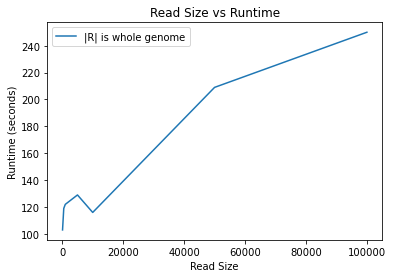

In [24]:
import matplotlib.pyplot as plt

# input size
x = [100, 500, 1000, 5000, 10000, 50000, 100000]

# runtime
y = [103, 119, 122, 129, 116, 209, 250]

plt.plot(x, y, label = "|R| is whole genome")
plt.xlabel('Read Size')
plt.ylabel('Runtime (seconds)')
plt.title('Read Size vs Runtime')
plt.legend()
plt.show()

# Running ReadMapper() on different N (|R| is 1/9 of the genome):

### Running ReadMapper() on 100 reads each 100 symbols long provides this output:
Running ReadMapper
100/100 sequences were mapped correctly

100 reads were done, with each read being 100 symbols long
Mapper took 26.816126823425293 seconds to run
<br>
<br>

### Running ReadMapper() on 500 reads each 100 symbols long provides this output:
Running ReadMapper
500/500 sequences were mapped correctly

500 reads were done, with each read being 100 symbols long
Mapper took 30.528393507003784 seconds to run
<br>
<br>

### Running ReadMapper() on 1000 reads each 100 symbols long provides this output:
Running ReadMapper
1000/1000 sequences were mapped correctly

1000 reads were done, with each read being 100 symbols long
Mapper took 7.45643424987793 seconds to run
<br>
<br>

### Running ReadMapper() on 5000 reads each 100 symbols long provides this output:
Running ReadMapper
5000/5000 sequences were mapped correctly

5000 reads were done, with each read being 100 symbols long
Mapper took 33.43825674057007 seconds to run
<br>
<br>

### Running ReadMapper() on 10000 reads each 100 symbols long provides this output:
Running ReadMapper
10000/10000 sequences were mapped correctly

10000 reads were done, with each read being 100 symbols long
Mapper took 32.39478588104248 seconds to run
<br>
<br>

### Running ReadMapper() on 50000 reads each 100 symbols long provides this output:
Running ReadMapper
50000/50000 sequences were mapped correctly

50000 reads were done, with each read being 100 symbols long
Mapper took 44.568172216415405 seconds to run
<br>
<br>

### Running ReadMapper() on 100000 reads each 100 symbols long provides this output:
Running ReadMapper
100000/100000 sequences were mapped correctly

100000 reads were done, with each read being 100 symbols long
Mapper took 57.37743425369263 seconds to run
<br>
<br>

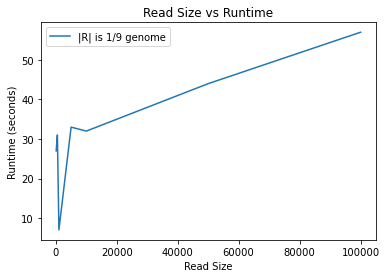

In [22]:
import matplotlib.pyplot as plt

# input size
x = [100, 500, 1000, 5000, 10000, 50000, 100000]

# runtime
y = [27, 31, 7, 33, 32, 44, 57]

plt.plot(x, y, label = "|R| is 1/9 genome")
plt.xlabel('Read Size')
plt.ylabel('Runtime (seconds)')
plt.title('Read Size vs Runtime')
plt.legend()
plt.show()

# Running ReadMapper() on different N (|R| is 1/3 of the genome):

### Running ReadMapper() on 100 reads each 100 symbols long provides this output:
Running ReadMapper
100/100 sequences were mapped correctly

100 reads were done, with each read being 100 symbols long
Mapper took 64.09707307815552 seconds to run
<br>
<br>

### Running ReadMapper() on 500 reads each 100 symbols long provides this output:
Running ReadMapper
500/500 sequences were mapped correctly

500 reads were done, with each read being 100 symbols long
Mapper took 91.4073646068573 seconds to run
<br>
<br>

### Running ReadMapper() on 1000 reads each 100 symbols long provides this output:
Running ReadMapper
1000/1000 sequences were mapped correctly

1000 reads were done, with each read being 100 symbols long
Mapper took 49.138524770736694 seconds to run
<br>
<br>

### Running ReadMapper() on 5000 reads each 100 symbols long provides this output:
Running ReadMapper
5000/5000 sequences were mapped correctly

5000 reads were done, with each read being 100 symbols long
Mapper took 95.24626970291138 seconds to run
<br>
<br>

### Running ReadMapper() on 10000 reads each 100 symbols long provides this output:
Running ReadMapper
10000/10000 sequences were mapped correctly

10000 reads were done, with each read being 100 symbols long
Mapper took 70.82056283950806 seconds to run
<br>
<br>

### Running ReadMapper() on 50000 reads each 100 symbols long provides this output:
Running ReadMapper
50000/50000 sequences were mapped correctly

50000 reads were done, with each read being 100 symbols long
Mapper took 99.67362594604492 seconds to run
<br>
<br>

### Running ReadMapper() on 100000 reads each 100 symbols long provides this output:
Running ReadMapper
100000/100000 sequences were mapped correctly

100000 reads were done, with each read being 100 symbols long
Mapper took 109.11843419075012 seconds to run
<br>
<br>

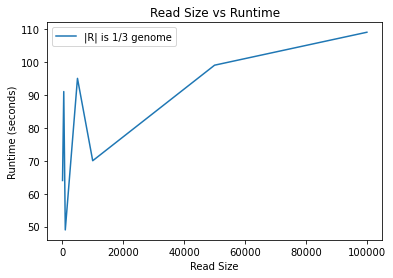

In [21]:
import matplotlib.pyplot as plt

# input size
x = [100, 500, 1000, 5000, 10000, 50000, 100000]

# runtime
y = [64, 91, 49, 95, 70, 99, 109]

plt.plot(x, y, label = "|R| is 1/3 genome")
plt.xlabel('Read Size')
plt.ylabel('Runtime (seconds)')
plt.title('Read Size vs Runtime')
plt.legend()
plt.show()

# Running ReadMapper() on different N (|R| is 1/2 of the genome):

### Running ReadMapper() on 100 reads each 100 symbols long provides this output:
Running ReadMapper
100/100 sequences were mapped correctly

100 reads were done, with each read being 100 symbols long
Mapper took 106.47621965408325 seconds to run
<br>
<br>

### Running ReadMapper() on 500 reads each 100 symbols long provides this output:
Running ReadMapper
500/500 sequences were mapped correctly

500 reads were done, with each read being 100 symbols long
Mapper took 88.22467589378357 seconds to run
<br>
<br>

### Running ReadMapper() on 1000 reads each 100 symbols long provides this output:
Running ReadMapper
1000/1000 sequences were mapped correctly

1000 reads were done, with each read being 100 symbols long
Mapper took 92.3170166015625 seconds to run
<br>
<br>

### Running ReadMapper() on 5000 reads each 100 symbols long provides this output:
Running ReadMapper
5000/5000 sequences were mapped correctly

5000 reads were done, with each read being 100 symbols long
Mapper took 57.216466426849365 seconds to run
<br>
<br>

### Running ReadMapper() on 10000 reads each 100 symbols long provides this output:
Running ReadMapper
10000/10000 sequences were mapped correctly

10000 reads were done, with each read being 100 symbols long
Mapper took 70.49220156669617 seconds to run
<br>
<br>

### Running ReadMapper() on 50000 reads each 100 symbols long provides this output:
Running ReadMapper
49706/49706 sequences were mapped correctly

49706 reads were done, with each read being 100 symbols long
Mapper took 110.99520230293274 seconds to run
<br>
<br>

### Running ReadMapper() on 100000 reads each 100 symbols long provides this output:
Running ReadMapper
98916/98916 sequences were mapped correctly

98916 reads were done, with each read being 100 symbols long
Mapper took 158.75822186470032 seconds to run
<br>
<br>

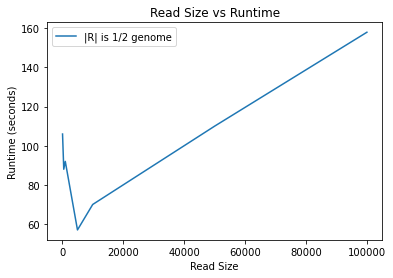

In [25]:
import matplotlib.pyplot as plt

# input size
x = [100, 500, 1000, 5000, 10000, 50000, 100000]

# runtime
y = [106, 88, 92, 57, 70, 110, 158]

plt.plot(x, y, label = "|R| is 1/2 genome")
plt.xlabel('Read Size')
plt.ylabel('Runtime (seconds)')
plt.title('Read Size vs Runtime')
plt.legend()
plt.show()

## All plots:

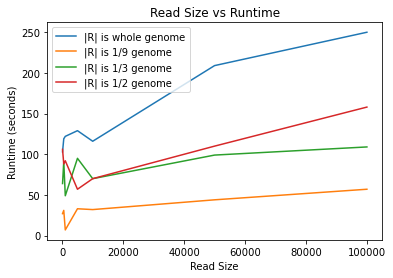

In [26]:
import matplotlib.pyplot as plt

# input size
x = [100, 500, 1000, 5000, 10000, 50000, 100000]

# runtime
y = [103, 119, 122, 129, 116, 209, 250]

plt.plot(x, y, label = "|R| is whole genome")

# input size
x = [100, 500, 1000, 5000, 10000, 50000, 100000]

# runtime
y = [27, 31, 7, 33, 32, 44, 57]

plt.plot(x, y, label = "|R| is 1/9 genome")

# input size
x = [100, 500, 1000, 5000, 10000, 50000, 100000]

# runtime
y = [64, 91, 49, 95, 70, 99, 109]

plt.plot(x, y, label = "|R| is 1/3 genome")

# input size
x = [100, 500, 1000, 5000, 10000, 50000, 100000]

# runtime
y = [106, 88, 92, 57, 70, 110, 158]

plt.plot(x, y, label = "|R| is 1/2 genome")

plt.xlabel('Read Size')
plt.ylabel('Runtime (seconds)')
plt.title('Read Size vs Runtime')
plt.legend()
plt.show()

# Conclusion:
### Time is linear for N, and time is super-linear for |R|
## Reasoning:
### Looking at the plot, we can see that each line scales evenly as N grows, so the time for N is linear. Also, looking at the plot, if we choose a value for read size, we see that there is a large different between each line for their runtime as |R| grows, so the time for |R| is super-linear. 
<br>
<br>
<br>
<br>
<br>

# Experiment (for fun):

# Compare to using re (regular expression) library

In [118]:
# Using re (regular expression) library
## YOUR CODE and EXPERIMENTAL RESULTS HERE
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import re
import time

def ReadMapper(R, S):
    # 1. Make dictionary from reads FASTA file
    gen_reads = {}
    for seq_record in SeqIO.parse(S, 'fasta'):
        curr_pos = seq_record.description
        curr_pos = curr_pos.split(' ')
        curr_pos = curr_pos[1]
        curr_sequence = str(seq_record.seq)
        gen_reads[curr_sequence] = int(curr_pos)
    
    # uncomment for small tests
    # print('Printing reads dictionary: {SEQUENCE: RANDOM_POSITION_IN_GENOME}\n', gen_reads, '\n')
    
    # 2. Read genome FASTA file and get genome
    genome = ''
    i = 0
    for seq_record in SeqIO.parse(R, 'fasta'):
        if i > 2:
            break
        genome += str(seq_record.seq)
        i += 1
    
    # 3. Find occurrence of each sequence in the genome 
    # and keep track of all positions of where its found
    seq_pos = {}
    for seq in gen_reads.keys():
        found_pos = [m.start() for m in re.finditer(seq, genome)]
        seq_pos[seq] = found_pos
        
    # uncomment for small tests
    # print('Printing all found positions dictionary: {SEQUENCE: [ALL_POSITIONS_IN_GENOME]}\n', seq_pos, '\n')
    
    # 4. Check how many sequences were mapped correctly
    correct_maps = 0
    expected_correct = len(gen_reads.keys())
    for seq in gen_reads.keys():
        map_pos = gen_reads[seq]
        all_pos = seq_pos[seq]
        
        if map_pos in all_pos:
            correct_maps += 1
    
    print(f'{correct_maps}/{expected_correct} sequences were mapped correctly\n')
    
    # 5. Print how many reads were done and the length of each read
    read_count = len(gen_reads.keys())
    read_length = len(list(gen_reads.keys())[0])
    print(f'{read_count} reads were done, with each read being {read_length} symbols long')


if __name__ == '__main__':
    print('Running ReadMapper')
    start = time.time()
    ReadMapper('bd_genome.fa', 'reads.fa')
    end = time.time()
    print(f'Mapper took {end - start} seconds to run')

Running ReadMapper
9979/9981 sequences were mapped correctly

9981 reads were done, with each read being 100 symbols long
Mapper took 130.8925266265869 seconds to run


# Running ReadMapper() on different N:

### Running ReadMapper() on 10 reads each 10 symbols long provides this output:
Running ReadMapper
Printing reads dictionary: {SEQUENCE: RANDOM_POSITION_IN_GENOME}
 {'GGGCCCAAAT': 1055201, 'CCAGGACCAT': 2468473, 'GAGAGCCAAA': 73571, 'GATCCCTTTG': 563087, 'ATAAAAACTG': 2194026, 'GGGCAATAAT': 581279, 'TCATTAATGG': 2171722, 'TTTTAAAAAC': 277464, 'CTTGATACAT': 1157445, 'ATGTCGTCCT': 1820428} 

Printing all found positions dictionary: {SEQUENCE: [ALL_POSITIONS_IN_GENOME]}
 {'GGGCCCAAAT': [122631, 838901, 1055201, 1218126], 'CCAGGACCAT': [2462696, 2465227, 2466667, 2468236, 2468473, 2468719, 2470279, 2472761, 2483183, 2483450, 2484395], 'GAGAGCCAAA': [73571, 1758937, 2114370], 'GATCCCTTTG': [563087, 771074, 3354088], 'ATAAAAACTG': [35930, 897746, 1276748, 1666209, 1767297, 1805892, 1930319, 1971354, 2194026, 2310222, 2368777, 2461918, 2462704, 2463508, 2464467, 2465235, 2466675, 2467467, 2468244, 2468481, 2468727, 2469255, 2470287, 2472550, 2472769, 2481559, 2483191, 2612208, 2704382, 2959577, 3078472, 3119847, 3299136], 'GGGCAATAAT': [182619, 436287, 581279, 2004843, 2097134, 3221096, 3402917], 'TCATTAATGG': [1545014, 1860090, 2118205, 2171722, 2186050, 2489101, 3078895, 3352985, 3363071], 'TTTTAAAAAC': [3341, 107118, 147498, 163847, 166169, 167259, 168310, 169365, 170419, 171474, 172525, 173576, 174627, 176693, 277464, 477362, 519093, 528980, 540758, 563603, 586025, 628987, 646042, 672467, 685136, 859411, 943560, 955343, 1119254, 1132804, 1237892, 1343909, 1351244, 1438767, 1555361, 1661846, 1749752, 1843328, 1862885, 2005560, 2023343, 2117418, 2134208, 2195662, 2204898, 2319888, 2325724, 2375366, 2429931, 2457807, 2523573, 2531407, 2707184, 2774453, 2785017, 2820807, 2849014, 2851292, 2855887, 2858170, 2867999, 2876937, 2961263, 3074709, 3341596, 3379867], 'CTTGATACAT': [694738, 1157445, 2155143, 2551565, 2768250], 'ATGTCGTCCT': [369371, 1820428, 1902327]} 

10/10 sequences were mapped correctly

10 reads were done, with each read being 10 symbols long:
Mapper took 0.28342747688293457 seconds to run
<br>
<br>

### Running ReadMapper() on 100 reads each 10 symbols long provides this output:
Running ReadMapper
100/100 sequences were mapped correctly

100 reads were done, with each read being 10 symbols long:
Mapper took 1.547407865524292 seconds to run
<br>
<br>

### Running ReadMapper() on 100 reads each 100 symbols long provides this output:
Running ReadMapper
100/100 sequences were mapped correctly

100 reads were done, with each read being 100 symbols long:
Mapper took 1.5418519973754883 seconds to run
<br>
<br>

### Running ReadMapper() on 1000 reads each 100 symbols long provides this output:
Running ReadMapper
1000/1000 sequences were mapped correctly

1000 reads were done, with each read being 100 symbols long:
Mapper took 13.530450820922852 seconds to run
<br>
<br>

### Running ReadMapper() on 10000 reads each 100 symbols long provides this output:
Running ReadMapper
9979/9981 sequences were mapped correctly

9981 reads were done, with each read being 100 symbols long:
Mapper took 130.8925266265869 seconds to run
<br>
<br>

## RE was faster at first, but then became very slow as N grew